In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import vice
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from vice_utils import calculate_z, sample_stars, filter_stars, show_stars, R_to_zone, zone_to_R, show_at_R_z
from yields import y_c_agb

In [94]:
def plot_c_table(study = "cristallo11"):
    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    cmap = plt.get_cmap('jet')
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i]
        z = z1[i]

        plt.plot(m1, y, label=f"Z = {z}", c=cmap(i/N))

    plt.xlabel("stellar mass")
    plt.ylabel("$y_C^{agb}$")
    # plt.legend()
    plt.title(study)

In [4]:
def plot_weighted_c_yields(study = "cristallo11", Z = 0.014):
    interpolator = vice.yields.agb.interpolator("c", study=study)
    
    masses = interpolator.masses
    y = [interpolator(m, Z) for m in masses]
    
    plt.plot(masses, np.array(y)*np.array(masses)**-1.3, label=study)

    plt.xlabel("stellar mass")
    plt.ylabel("$y_C^{agb}$")
    plt.legend()

In [5]:
%cd ~/surp/figures

/users/PAS2232/aeyobd/surp/figures


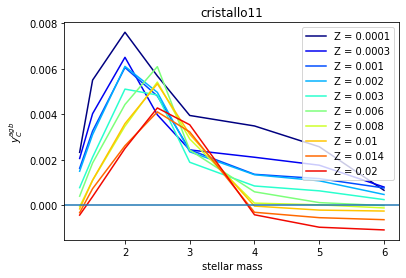

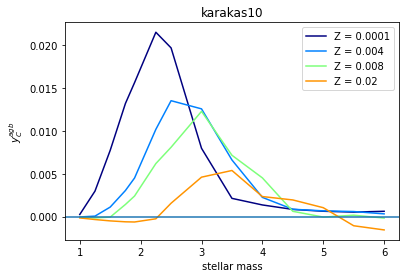

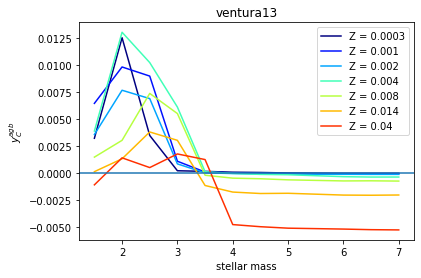

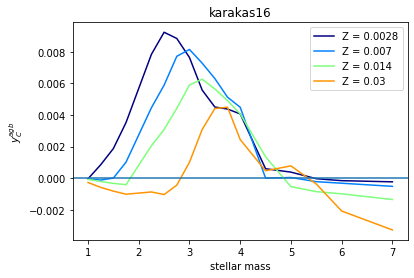

In [35]:
for study in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    plot_c_table(study)
    plt.axhline(0)
    name = "yields_C_agb_to_mass_" + study
    plt.savefig(name + ".pdf")
    plt.savefig(name + ".jpeg")
    
    plt.show()
    

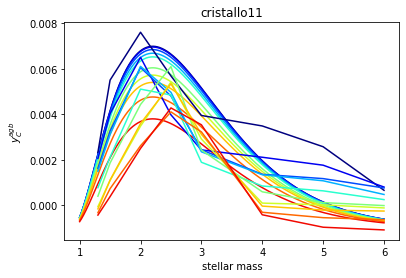

In [218]:
Z_vals = [0.0001,0.0003,0.001,0.002,0.003,0.006, 0.008, 0.01, 0.014, 0.02]
cmap = plt.get_cmap("jet")
for i in range(len(Z_vals)):
    Z = Z_vals[i]
    x = np.linspace(1, 6, 1000)
    y = y_c_agb(b0=-0.001)(x, Z)
    plt.plot(x, y, label=Z, c=cmap(i/len(Z_vals)))
    
plot_c_table()

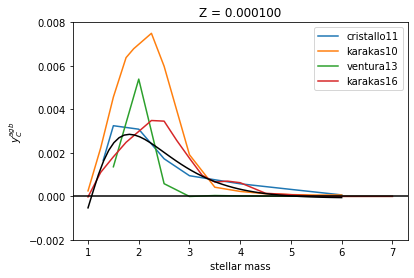

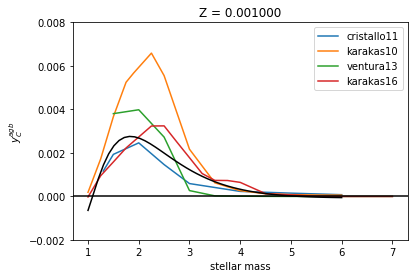

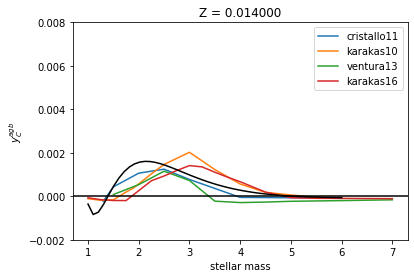

In [220]:
for Z in [0.0001, 0.001, 0.014]:
    for study in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
        plot_weighted_c_yields(study, Z=Z)

    plt.axhline(0, c="black")
    plt.title("Z = %f" % Z)

    name = "weighted_yields_C_agb_to_mass_logZ%i" % (np.log10(Z))
    plt.savefig(name + ".pdf")
    plt.savefig(name + ".jpeg")
    x = np.linspace(1, 6)
    y = y_c_agb(b0=-0.001)(x, Z)*x**-1.3
    plt.plot(x, y, c="black")
    plt.ylim(-0.002, 0.008)
    plt.show()

In [8]:
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    "CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }
allowed_rotations = {
    "LC18": [0, 150, 300],
    "S16/N20": [0],
    "CL13": [0, 300],
    "NKT13": [0],
    "CL04": [0],
    "WW95": [0]
}

ccsne_studies = ["LC18", "S16/N20", "CL13","CL04","WW95","NKT13"]
cmap = plt.get_cmap("jet")
N = len(ccsne_studies)

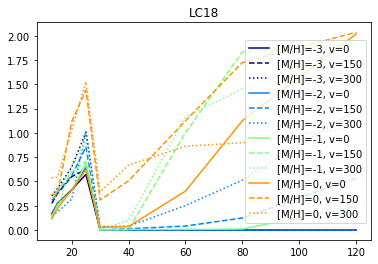

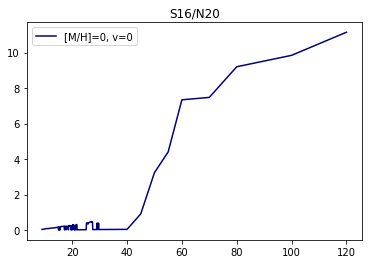

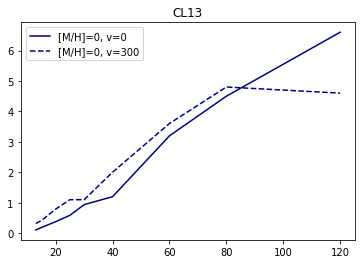

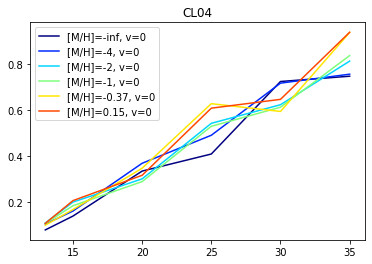

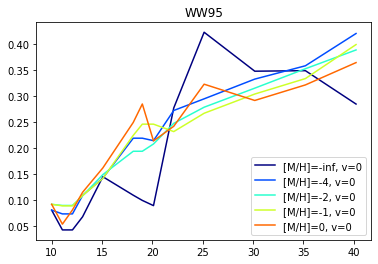

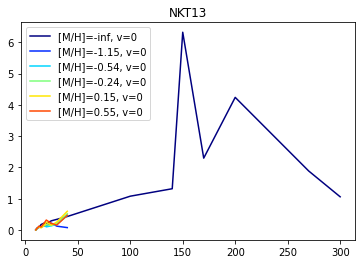

In [9]:
for study in ccsne_studies:
    metalicities = allowed_MoverH[study]
    
    N = len(metalicities)
    rotations = allowed_rotations[study]
    for i in range(N):
        for j in range(len(rotations)):
            rotation = rotations[j]
            MoverH = metalicities[i]
            table = vice.yields.ccsne.table("c", study=study, MoverH=MoverH, rotation=rotation)
            masses = table.masses
            yields = [table[mass] for mass in masses]

            plt.plot(masses, yields, label=f"[M/H]={MoverH}, v={rotation}", color=cmap(i/N), linestyle=["-", "--", ":"][j])
        
    plt.title(study)
    plt.legend()
    
    name = "yields_C_ccsne_to_mass_" + study.replace("/", "")
    plt.savefig(name + ".pdf")
    plt.savefig(name + ".jpeg")
    plt.show()

/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:9: ScienceWarning: Supernovae yields from the Chieffi & Limongi (2004), ApJ, 608, 405 study are sampled on a grid of stellar masses up to 35 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  if __name__ == '__main__':
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:9: ScienceWarning: Supernovae yields from the Woosley & Weaver (1995) ApJ, 101, 181 study are sampled on a grid of stellar masses up to 40 Msun at this metallicity. Employing an upper mass limit larger than this may introduce numerical artifacts. Got: 100 Msun
  if __name__ == '__main__':
/apps/project/ondemand/app_jupyter/3.0.17/lib64/python3.6/site-packages/ipykernel_launcher.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only re

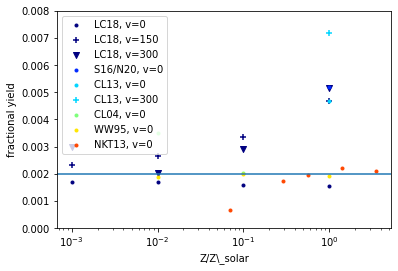

In [10]:
for i in range(N):
    study=ccsne_studies[i]
    metalicities = allowed_MoverH[study]
    rotations = allowed_rotations[study]
    
    for j in range(len(rotations)):
        rotation = rotations[j]
        y = [vice.yields.ccsne.fractional('c', study=study, MoverH=metalicity, rotation=rotation)[0]
             for metalicity in metalicities]
        
        Z = list(map(lambda x: 10**x, metalicities))
        plt.scatter(Z, y, color=cmap(i/N), label=f"{study}, v={rotation}", marker=[".", "+", "v"][j])

plt.legend()
plt.axhline(0.002)
plt.xscale("log")
plt.ylim([0, 0.008])
plt.xlabel("Z/Z\_solar")
plt.ylabel("fractional yield")
name = "CCSN_C_yields_to_Z"
plt.savefig(name + ".pdf")
plt.savefig(name + ".jpeg")

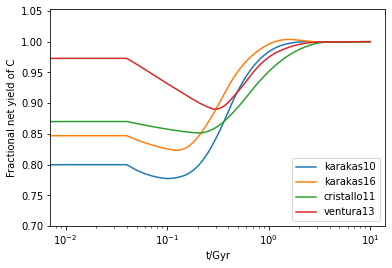

In [11]:
for model in ["karakas10", "karakas16", "cristallo11", "ventura13"]:
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c")
    plt.plot(times, np.array(m_c)/m_c[-1], label=model)
plt.xlabel("t/Gyr")
plt.ylabel("Fractional net yield of C")
plt.xscale("log")
plt.legend()
plt.ylim(0.7)
name = "y_C_agb_to_t"
plt.savefig(name + ".pdf")
plt.savefig(name + ".jpeg")

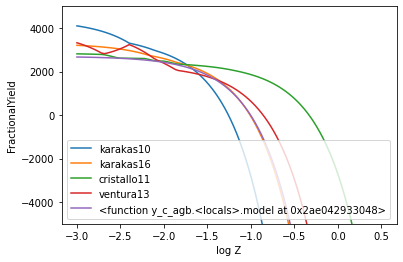

In [215]:
for model in ["karakas10", "karakas16", "cristallo11", "ventura13", y_c_agb()]:
    vice.yields.agb.settings["c"] = model
    Zs = 10**np.linspace(-3, 0.5, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    
    plt.plot(np.log10(Zs), mass_yields, label=model)
plt.xlabel("log Z")
plt.ylabel("FractionalYield")
plt.ylim(-5e3, 5e3)

name = "y_C_AGB_to_Z"

plt.legend()

plt.savefig(name + ".pdf")
plt.savefig(name + ".jpeg")